# Colors for SNLS for a AB source

- Author Sylvie Dagoret-Campagne
- date April 23rd 2018


Process SED with galactic extinction



In [1]:
import numpy as np
import pandas as pd
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.jet
%matplotlib inline

In [2]:
import os
import sys

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
top_pysynphot_data_dir=os.environ['PYSYN_CDBS']

In [5]:
cfht_transmissionfile="./all_SNLS_transm.csv"

In [6]:
sys.path.append('./snlsphotometry')
sys.path.append('../DESCDec2017/pysynphotsed')

In [7]:
import libSNLSPhotometry as photo
import libCFHTFilters as cfht
#import libpysynphotsed as sed
import libpysynphotgridsed as sed

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 101787.601976


In [8]:
import astropy
import astropy.units as u
from astropy.io import fits

In [9]:
import pysynphot as S
S.primary_area=1.02e5
S.binning=1.

# CFHT Telescope

In [10]:
CFHT_COLL_SURF=np.pi/4.*(3.6*u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [11]:
NBINS=int(WLMAX-WLMIN)
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [12]:
CFHT_COLL_SURF.decompose()

<Quantity 101787.6019763093>

In [13]:
S.refs.setref(area=CFHT_COLL_SURF.decompose(), waveset=None)

In [14]:
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMIN, num=NBINS, delta=1, log=False)

In [15]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000.0, Max: 3000.0, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 101787.601976


# Sources

## AB source

In [16]:
10**(S.units.ABZERO/2.5)

3.630780547701003e-20

In [17]:
calib_source=S.FlatSpectrum(10**(S.units.ABZERO/2.5),fluxunits='fnu')
calib_source.convert('photlam')
print calib_source.flux

[]


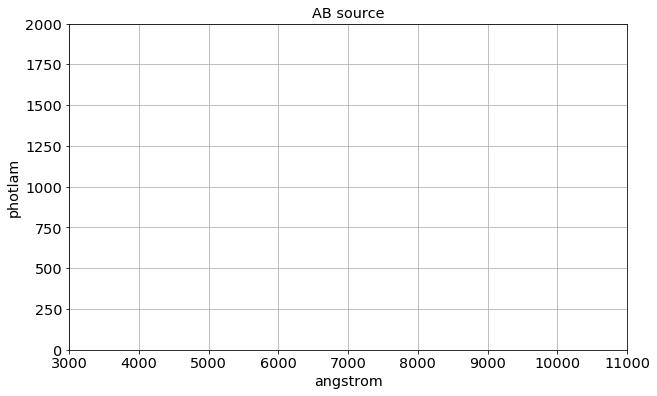

In [18]:
plt.plot(calib_source.wave,calib_source.flux,'r-')
plt.xlabel(calib_source.waveunits)
plt.ylabel(calib_source.fluxunits)
plt.title("AB source")
plt.ylim(0,2000.)
plt.xlim(3000.,11000.)
plt.grid()

In [19]:
all_sed=[calib_source]
all_indexes=[0]

# Number of independant catalog

In [20]:
all_sed_collection= []
all_sedmodels_tag=[]

In [21]:
all_sed_collection.append(all_sed)
all_sedmodels_tag.append('AB')

In [22]:
NBCATALOGS=len(all_sedmodels_tag)

In [23]:
NBCATALOGS

1

# Retrieve Filters

In [24]:
bp_u,bp_g,bp_r,bp_i,bp_z=cfht.GetAllCFHTBands(cfht_transmissionfile)

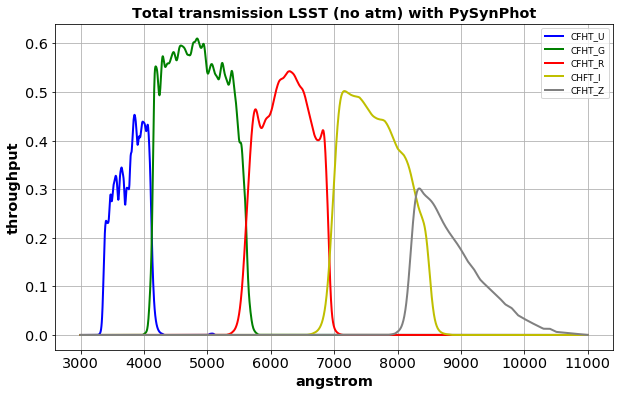

In [25]:
cfht.PlotAllCFHTBands(bp_u,bp_g,bp_r,bp_i,bp_z)

# Create LSST Detector

In [26]:
cfhtdetector=photo.SNLSTransmission('cfhtel')

In [27]:
cfhtdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z])

# Get CFHT Atmosphere

In [28]:
photo_atm=photo.Atmosphere('SNLS atmosphere')

In [29]:
df=pd.read_csv(cfht_transmissionfile)
df.sort_index(axis=0,ascending=True,inplace=True)     
wl_atm=df["lambda"]
tr_atm=df["atm"]
wl_atm=np.array(wl_atm)   
tr_atm=np.array(tr_atm)
photo_atm.fill_array(wl_atm)        
photo_atm.fill_array(tr_atm)  

In [30]:
theatmosph=photo_atm.get_array()

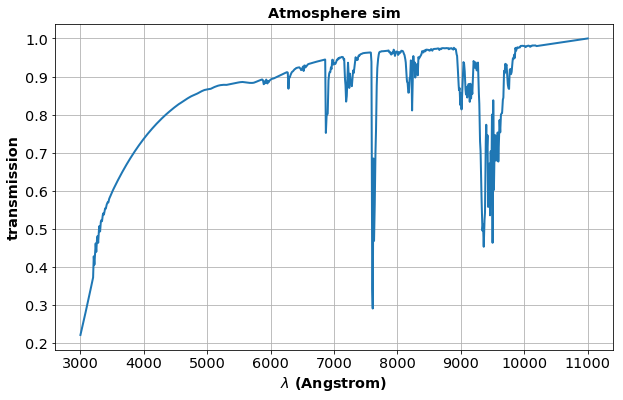

In [31]:
photo_atm.plot_pys_bp()

In [32]:
all_bp_atm=photo_atm.get_pys_pb()

In [33]:
cfhtdetector.fill_atm_allevents(all_bp_atm)

In [34]:
all_transmissions=cfhtdetector.make_transmissions()

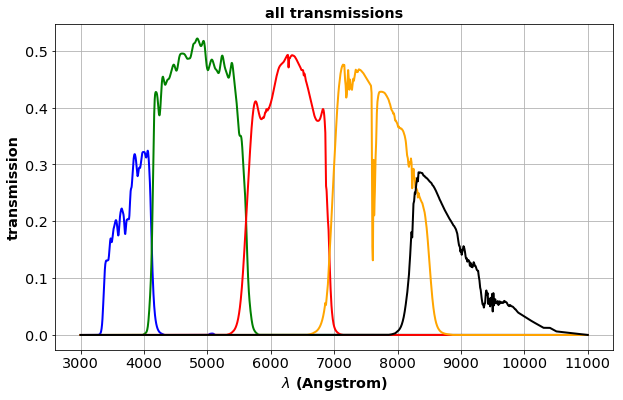

In [35]:
cfhtdetector.plot_transmissions()

# Calculation of all Observations for each SED colors

In [36]:
all_observations_collection = []
all_observations_zeropt_collection = []

In [37]:
np.arange(NBCATALOGS)

array([0])

In [38]:
for id_model in np.arange(NBCATALOGS):
    the_obs_name="SNLS_models-{}".format(all_sedmodels_tag[id_model])  
    print id_model, the_obs_name
    the_observation=photo.SNLSObservation(the_obs_name)            # create a set of observation 
    the_observation.fill_sed(all_sed_collection[id_model])         # get the SED from the SED model model
    the_observation.fill_transmission(all_transmissions)           # provide LSST Trroughput transmission
    the_observation.make_observations()                            # start calculations 
    the_observation.make_samplobservations()
    the_observation.compute_counts()
    the_observation.compute_magnitude()
    the_observation.compute_colors()
    all_observations_collection.append(the_observation)

0 SNLS_models-AB
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


# Check

In [39]:
len(all_observations_collection)

1

In [40]:
ModelSelect=0
ObjectSelect=0

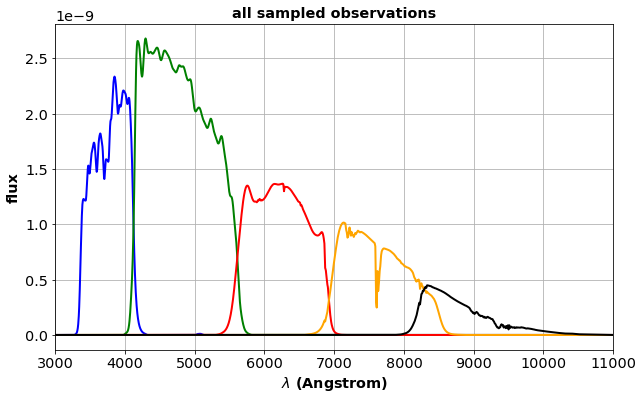

In [41]:
all_observations_collection[ModelSelect].plot_samplobservations(ObjectSelect)

# Work with magnitudes

In [42]:
all_magnitudes=np.array(all_observations_collection[ModelSelect].get_magnitudes())

In [43]:
print len(all_magnitudes)

1


In [44]:
type(all_magnitudes)

numpy.ndarray

In [45]:
all_magnitudes0=all_magnitudes[:,0,:]

In [46]:
all_magnitudes0.shape

(1, 5)

In [47]:
dfm=pd.DataFrame(data=all_magnitudes0,columns=["u","g","r","i","z"])

In [48]:
dfm.head()

,u,g,r,i,z
0,-26.067607,-27.247487,-26.748204,-26.589117,-25.632748


In [49]:
dfm["idxcat"]=all_indexes
dfm=dfm.reindex(['idxcat','u','g','r','i','z'], axis=1)

In [50]:
dfm.head()

,idxcat,u,g,r,i,z
0,0,-26.067607,-27.247487,-26.748204,-26.589117,-25.632748


In [51]:
dfm.to_csv("ab_snlsmagnit_Noextinct.csv")

# Work with colors

In [52]:
all_colors=all_observations_collection[ModelSelect].get_colors()

In [53]:
all_colors.shape

(1, 1, 4)

1 1


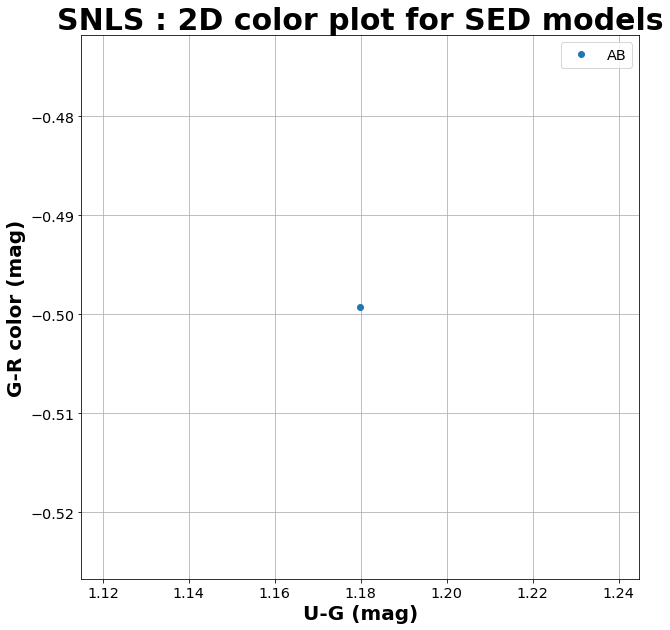

In [54]:
plt.figure(figsize=(10,10))
for id_model in np.arange(NBCATALOGS):
    all_colors=all_observations_collection[id_model].get_colors()
    c1=all_colors[:,0,0]
    c2=all_colors[:,0,1]
    print len(c1),len(c2)
    plt.plot(c1,c2,'o',label=all_sedmodels_tag[id_model])
    
plt.grid()

xtitle='U-G (mag)'
ytitle='G-R color (mag)'
title='SNLS : 2D color plot for SED models'
plt.xlabel(xtitle,fontsize=20,weight='bold')
plt.ylabel(ytitle,fontsize=20,weight='bold')        
plt.title(title,fontsize=30,weight='bold')    
plt.legend()    
    

In [55]:
id_phoenix_model=0
all_colors=all_observations_collection[id_phoenix_model].get_colors()
c1=all_colors[:,0,0]
c2=all_colors[:,0,1]
c3=all_colors[:,0,2]
c4=all_colors[:,0,3]

In [56]:
df=pd.DataFrame({'u-g':c1,'g-r':c2,'r-i':c3,'i-z':c4})

In [57]:
df = df.reindex(['u-g','g-r','r-i','i-z'], axis=1)
#df = df.reindex(['u-g','g-r','r-i','i-z'], axis=1)
#df = df.reindex_axis(['u-g','g-r','r-i','i-z'], axis=1)

In [58]:
df.head()

,u-g,g-r,r-i,i-z
0,1.17988,-0.499284,-0.159087,-0.956369


In [59]:
df.to_csv("ab_snlscol_Noextinct.csv")